In [1]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')
import nibabel as nb 
import scipy.io as io
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from nilearn import plotting
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

Populating the interactive namespace from numpy and matplotlib


### Names of the ROIs (brain regions of interest) and dataset with clinical labels and subjects ID

In [2]:
masks = ['rPascual_3','rPascual_27','rPascual_32','rPascual_19','rPascual_35',
         'rback','rback2','rback3','rback4','rback5', 'rback6','rback7',     
         'rPascual_3_right','rPascual_27_right','rPascual_32_right','rPascual_19_right','rPascual_35_right',
         'rback_right','rback2_right','rback3_right','rback4_right','rback5_right', 'rback6_right','rback7_right']

df = pd.read_excel('full.xlsx')  # ID, IMG, LABEL

### Save average brain atrophy map according to clinical labels

In [3]:
cluster1 = df[df.Label==0]
cluster2 = df[df.Label==1]

strings = cluster1.IMG.values.astype(np.str)
brain = np.zeros(shape=(len(strings),121,145,121))
for i in range(len(cluster1.IMG)):        
    tmp = glob.glob('/Users/vborghesani/Desktop/ScienceHack/wmaps/*%s' % strings[i])[0]
    tmp2 = tmp + '/T1-long/wmap.nii'
    tmp3 = nb.load(tmp2)
    if i == 1:
        affine = nb.load(tmp2).get_affine()
    brain[1,:,:,:] = tmp3.get_data()
result_3D = np.mean(brain,0)*-1
img = nb.Nifti1Image(result_3D, affine)
nb.save(img, 'cluster_neuro1.nii')

strings = cluster2.IMG.values.astype(np.str)
brain = np.zeros(shape=(len(strings),121,145,121))
for i in range(len(cluster2.IMG)):        
    tmp = glob.glob('/Users/vborghesani/Desktop/ScienceHack/wmaps/*%s' % strings[i])[0]
    tmp2 = tmp + '/T1-long/wmap.nii'
    tmp3 = nb.load(tmp2)
    if i == 1:
        affine = nb.load(tmp2).get_affine()
    brain[1,:,:,:] = tmp3.get_data()
result_3D = np.mean(brain,0)*-1
img = nb.Nifti1Image(result_3D, affine)
nb.save(img, 'cluster_neuro2.nii')

### Get average atrophy level in each ROI

In [4]:
Results= np.zeros(shape=(99,len(masks)))

for i in range(99):
    for j, M in enumerate(masks):
        
        # load subject data
        tmp = glob.glob('/Users/vborghesani/Desktop/ScienceHack/wmaps/*%s' % df.IMG[i])[0]
        tmp2 = tmp + '/T1-long/wmap.nii'
        tmp3 = nb.load(tmp2)
        brain = tmp3.get_data()
        # load and apply mask
        tmp = nb.load('/Users/vborghesani/Desktop/ScienceHack/ROIs/%s.nii' % M)
        mask = tmp.get_data().astype(np.bool)
        # store results
        Results[i,j] = np.mean(np.array(brain[mask].ravel()))

### Try clustering of the patients according to their brain atrophy

('For n_clusters =', 2, 'The average silhouette_score is :', 0.30103575021667267)


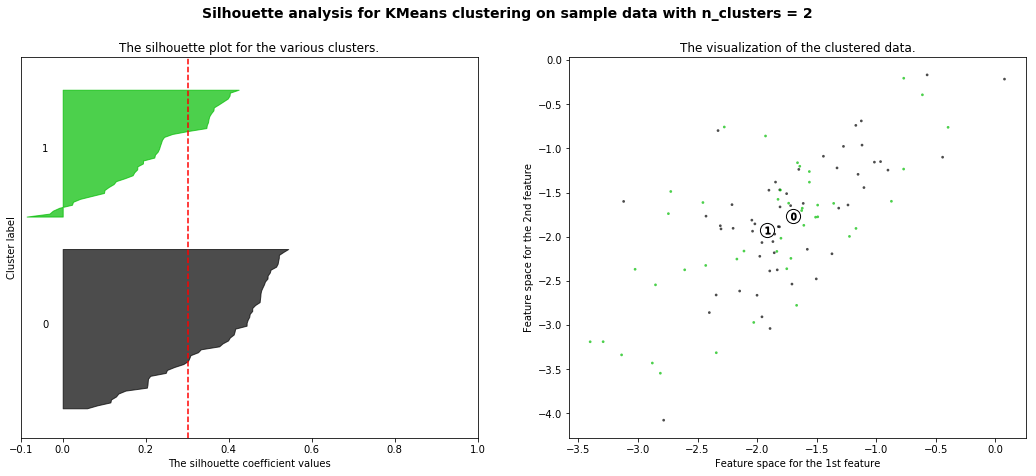

('For n_clusters =', 3, 'The average silhouette_score is :', 0.31107256832694691)


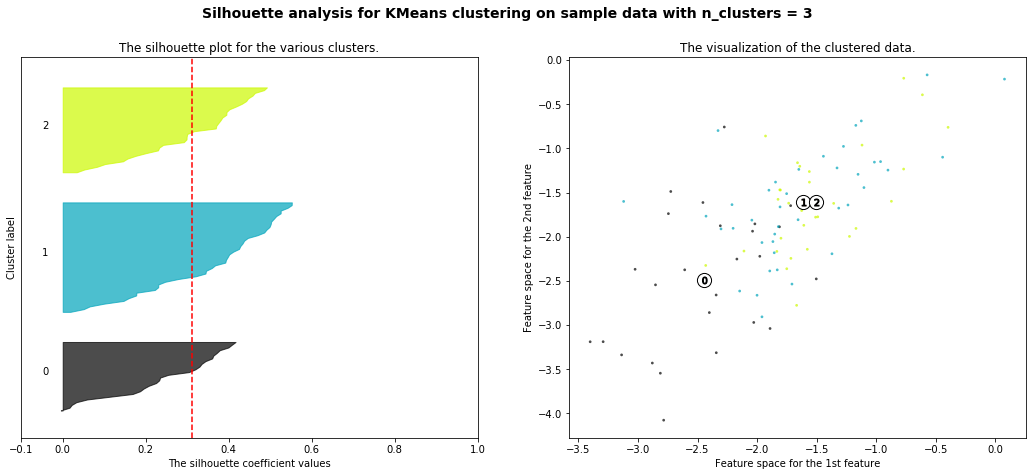

('For n_clusters =', 4, 'The average silhouette_score is :', 0.29033489922875655)


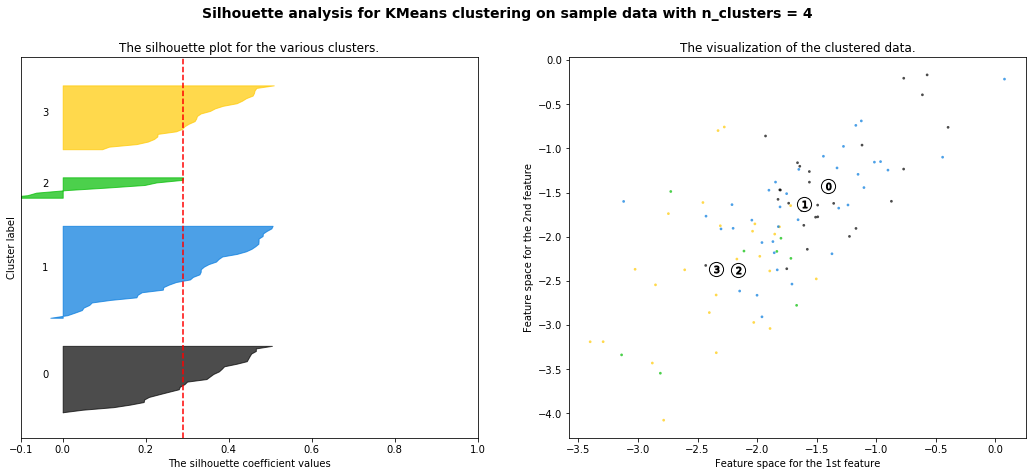

('For n_clusters =', 5, 'The average silhouette_score is :', 0.24832976247200822)


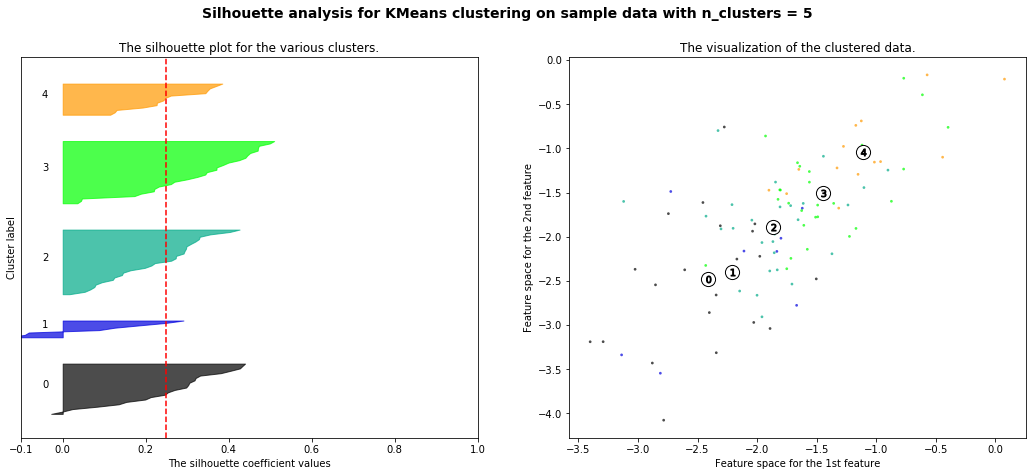

In [5]:
X = Results
range_n_clusters = [2,3,4,5]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

### It seems that 3 is the best number of clusters, save average atrophy map

In [6]:
clf = KMeans(n_clusters=3,random_state=10).fit(Results)
cluster1 = df[clf.labels_==0]
cluster2 = df[clf.labels_==1]
cluster3 = df[clf.labels_==2]

In [7]:
strings = cluster1.IMG.values.astype(np.str)
brain = np.zeros(shape=(len(strings),121,145,121))
for i in range(len(cluster1.IMG)):        
    tmp = glob.glob('/Users/vborghesani/Desktop/ScienceHack/wmaps/*%s' % strings[i])[0]
    tmp2 = tmp + '/T1-long/wmap.nii'
    tmp3 = nb.load(tmp2)
    if i == 1:
        affine = nb.load(tmp2).get_affine()
    brain[1,:,:,:] = tmp3.get_data()
result_3D = np.mean(brain,0)*-1
img = nb.Nifti1Image(result_3D, affine)
nb.save(img, 'cluster1.nii')

In [8]:
strings = cluster2.IMG.values.astype(np.str)
brain = np.zeros(shape=(len(strings),121,145,121))
for i in range(len(cluster2.IMG)):        
    tmp = glob.glob('/Users/vborghesani/Desktop/ScienceHack/wmaps/*%s' % strings[i])[0]
    tmp2 = tmp + '/T1-long/wmap.nii'
    tmp3 = nb.load(tmp2)
    if i == 1:
        affine = nb.load(tmp2).get_affine()
    brain[1,:,:,:] = tmp3.get_data()
result_3D = np.mean(brain,0)*-1
img = nb.Nifti1Image(result_3D, affine)
nb.save(img, 'cluster2.nii')

In [9]:
strings = cluster3.IMG.values.astype(np.str)
brain = np.zeros(shape=(len(strings),121,145,121))
for i in range(len(cluster3.IMG)):        
    tmp = glob.glob('/Users/vborghesani/Desktop/ScienceHack/wmaps/*%s' % strings[i])[0]
    tmp2 = tmp + '/T1-long/wmap.nii'
    tmp3 = nb.load(tmp2)
    if i == 1:
        affine = nb.load(tmp2).get_affine()
    brain[1,:,:,:] = tmp3.get_data()
result_3D = np.mean(brain,0)*-1
img = nb.Nifti1Image(result_3D, affine)
nb.save(img, 'cluster3.nii')

### Plot maps of the different clusters  - both data-driven and clinically defined

In [10]:
nifti_cluster1 = '/Users/vborghesani/Desktop/ScienceHack/cluster1.nii'
nifti_cluster2 = '/Users/vborghesani/Desktop/ScienceHack/cluster2.nii'
nifti_cluster3 = '/Users/vborghesani/Desktop/ScienceHack/cluster3.nii'

nifti_neuro1 = '/Users/vborghesani/Desktop/ScienceHack/cluster_neuro1.nii'
nifti_neuro2 = '/Users/vborghesani/Desktop/ScienceHack/cluster_neuro2.nii'

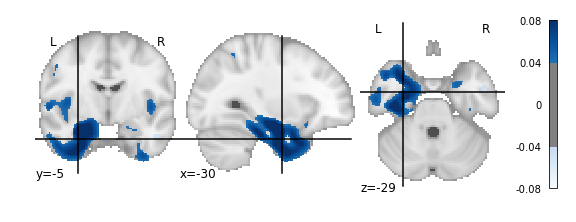

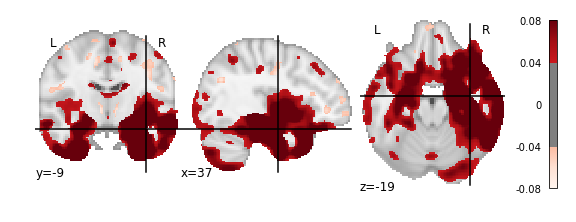

In [11]:
plotting.plot_stat_map(nifti_neuro1, threshold=0.04, colorbar=True, vmax=0.08,cmap='Blues')
plotting.plot_stat_map(nifti_neuro2, threshold=0.04, colorbar=True, vmax=0.08,cmap='Reds')
plt.show()

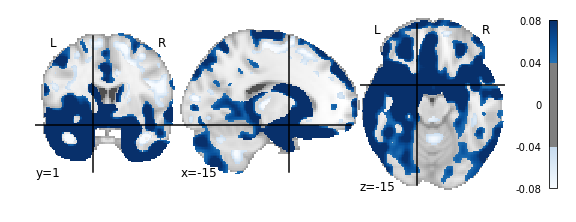

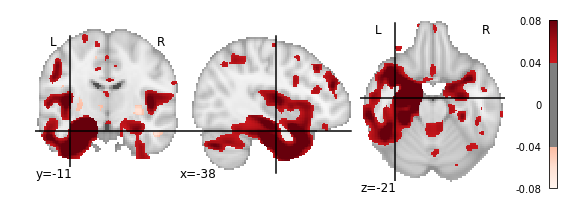

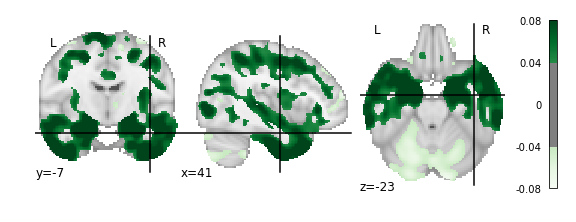

In [12]:
plotting.plot_stat_map(nifti_cluster1, threshold=0.04, colorbar=True, vmax=0.08,cmap='Blues')
plotting.plot_stat_map(nifti_cluster2, threshold=0.04, colorbar=True, vmax=0.08,cmap='Reds')
plotting.plot_stat_map(nifti_cluster3, threshold=0.04, colorbar=True, vmax=0.08,cmap='Greens')
plt.show()